# Visualise differential expression analysis results with MA plot

I-Hsuan Lin

University of Manchester

February 08, 2021

## 1. Introduction

This notebook shows readers how to use `ggplot2` package to create various plots to show the magnitude of the change in expression between two groups (M) in comparison to the magnitude of average expression over all samples (A).

### About this dataset

The RNA-seq dataset [E-MTAB-8411](https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-8411) contains 5 wild-type (GK1, GK3, GK5, GK7 and GK9) and 4 macrophage-specific *Bmal1* knockout samples (GK2, GK4, GK6 and GK10). The fastq files were retreived from [ArrayExpress](https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-8411/samples/) and processed with the follow steps:

1. Adapter and QC trimming with `BBDuk`
2. Mapping to Mouse genome (assemble MM10 and [GENCODE M24](https://www.gencodegenes.org/mouse/release_M24.html) annotation) with `STAR`
3. Differential expression analysis with `DESeq2`. *The log2 fold change shrinkage was not applied.*

## 2. Loading required libraries

In [1]:
library(data.table)
library(ggplot2)
library(ggrepel)
library(scales)

## 3. Set output parameters

In [2]:
# Set width
options(width = 110)

# Set output image size
options(repr.plot.width = 12, repr.plot.height = 8, repr.plot.res = 150)

## 4. Retrieve example results

The `data.frame` should contain at least the average expression and log2 fold change (or fold change) information in order for one to produce MA plot.

In [3]:
data <- fread("https://raw.githubusercontent.com/ycl6/Simple-R-gists/main/RNA-seq_DEA_MA-plot/DESeq2_DEG.txt")
head(data, 10)

GeneID,GeneSymbol,basemean,log2fc,pvalue,padj
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
ENSMUSG00000000001.4,Gnai3,5879.8720170,0.08804493,0.1925609,0.6146732
ENSMUSG00000000003.15,Pbsn,0.0000000,NA,NA,NA
ENSMUSG00000000028.15,Cdc45,58.7318213,-0.32106635,0.1401127,0.5331437
ENSMUSG00000000031.16,H19,0.2167807,-1.20339889,0.7161464,NA
ENSMUSG00000000037.17,Scml2,7.1733001,-0.57746426,0.2979159,NA
ENSMUSG00000000049.11,Apoh,0.1083165,-0.62633006,0.8517969,NA
ENSMUSG00000000056.7,Narf,812.4468253,-0.01158591,0.9159233,0.9836250
ENSMUSG00000000058.6,Cav2,1269.8101985,0.05719916,0.6390270,0.9078588
ENSMUSG00000000078.7,Klf6,4840.8443832,0.04163915,0.5098946,0.8543014


## 5. Create plots

### Prepare plot settings

In [4]:
# Set alpha
alpha = 0.05

# Evaluate if adjusted P-values is smaller than alpha 
data$isDE = ifelse(is.na(data$padj), FALSE, data$padj < alpha)
table(isDE = data$isDE)

# Subset result to genes with detectable expression
# Genes with 0 expression will not be able to show on log-scaled MA plot, removed to prevent warning message
data = subset(data, basemean != 0)

# Show log2 fold change distribution
print("log2 fold change distribution:")
round(quantile(data$log2fc),2)

# Use log2 fold change distribution to set an appropriate Y-axis limits
# Set limit at 99th quantile to ensure there are some genes exceeding the limits,
# and they will be shown as different shapes
ylim = quantile(abs(data$log2fc[is.finite(data$log2fc)]), probs = 0.99)
# Use floor() to set lower bound and create upper and lower limits
ylim = c(-1,1) * (floor(ylim * 2) / 2)

print(paste("Y-axis lower bound:", ylim[1]))
print(paste("Y-axis upper bound:", ylim[2]))

# Re-scale fold change to within ylim upper and lower limits
data$log2fc2 = pmax(ylim[1], pmin(ylim[2], data$log2fc))

# Determine shape type
# A: If smaller than lower limit - down-pointing triangle
# B: If larger than upper limit - up-pointing triangle
# C: Within upper and lower limits - round circle
data$shape = ifelse(data$log2fc < ylim[1], "A", ifelse(data$log2fc > ylim[2], "B", "C"))

isDE
FALSE  TRUE 
54573   812 

[1] "log2 fold change distribution:"


0%   25%   50%   75%  100% 
-6.06 -0.23  0.00  0.24  4.42

[1] "Y-axis lower bound: -2"
[1] "Y-axis upper bound: 2"


In [5]:
head(data)

GeneID,GeneSymbol,basemean,log2fc,pvalue,padj,isDE,log2fc2,shape
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<chr>
ENSMUSG00000000001.4,Gnai3,5879.8720170,0.08804493,0.1925609,0.6146732,FALSE,0.08804493,C
ENSMUSG00000000028.15,Cdc45,58.7318213,-0.32106635,0.1401127,0.5331437,FALSE,-0.32106635,C
ENSMUSG00000000031.16,H19,0.2167807,-1.20339889,0.7161464,NA,FALSE,-1.20339889,C
ENSMUSG00000000037.17,Scml2,7.1733001,-0.57746426,0.2979159,NA,FALSE,-0.57746426,C
ENSMUSG00000000049.11,Apoh,0.1083165,-0.62633006,0.8517969,NA,FALSE,-0.62633006,C
ENSMUSG00000000056.7,Narf,812.4468253,-0.01158591,0.9159233,0.9836250,FALSE,-0.01158591,C


### Create MA plot

Here, we use the *re-scaled* log2 fold change values for `y` aesthetics, and all the data points will be within the specified Y-axis limits. Data points that originally exceed the Y-axis limits will be shown as either up-pointing or down-pointing triangles.

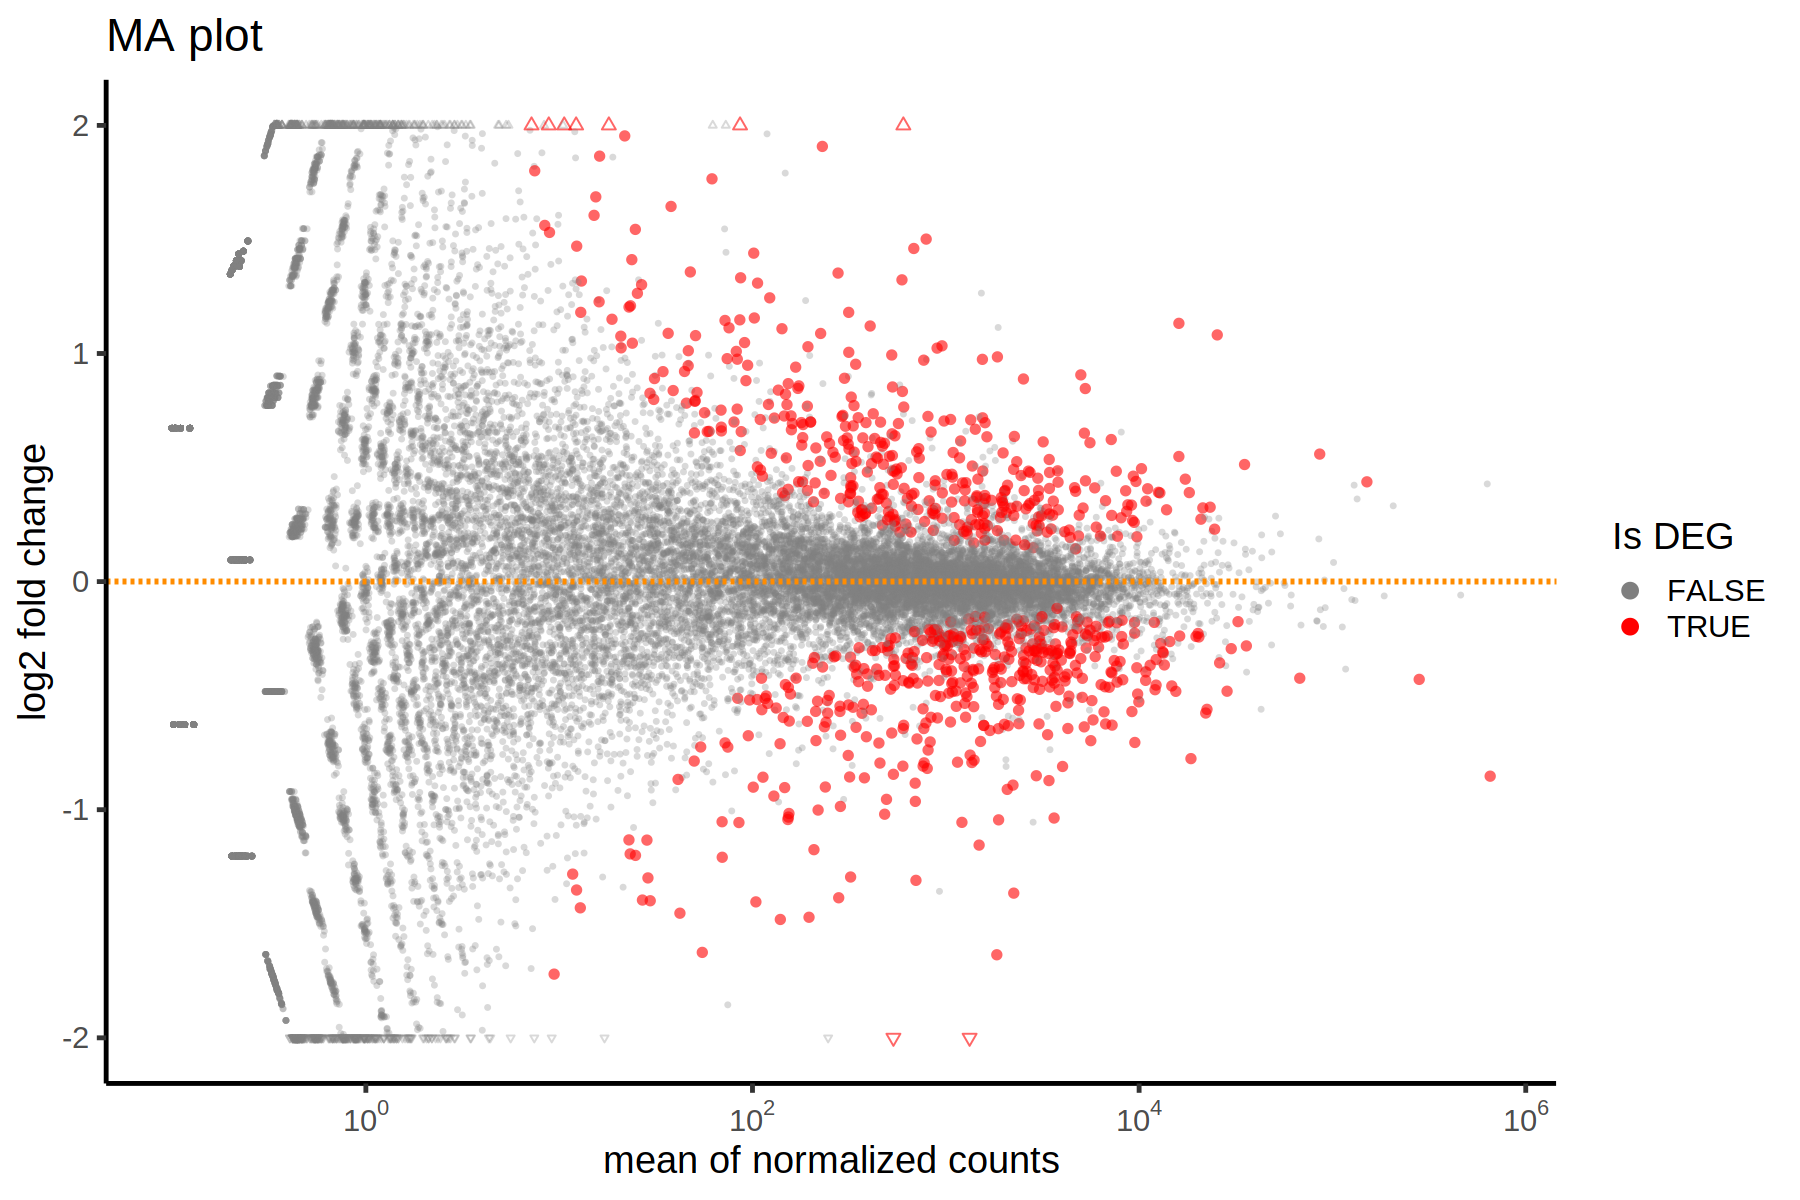

In [6]:
# Set log10 breaks and labels
log10break = trans_breaks("log10", function(x) 10^x)
log10label = trans_format("log10", math_format(10^.x))
                          
ggplot(data, aes(x = basemean, y = log2fc2, color = isDE, size = isDE, alpha = isDE, shape = shape)) + 
    geom_point() + theme_classic(base_size = 18) + 
    geom_hline(yintercept = 0, size = 1, color = "darkorange", linetype = "dashed") +
    scale_x_log10(breaks = log10break, labels = log10label) + 
    scale_y_continuous(limits = ylim) +
    scale_color_manual(name = "Is DEG", values = setNames(c("red", "gray50"), c(TRUE, FALSE))) +
    scale_alpha_manual(guide = FALSE, values = setNames(c(0.6, 0.3), c(TRUE, FALSE))) + 
    scale_size_manual(guide = FALSE, values = setNames(c(2, 1), c(TRUE, FALSE))) +
    scale_shape_manual(guide = FALSE, values = setNames(c(6, 2, 16), c("A", "B", "C"))) +
    guides(color = guide_legend(override.aes = list(size = 3))) +
    ggtitle("MA plot") + xlab("mean of normalized counts") + ylab("log2 fold change")

In [7]:
# Show up-regulated genes beyong Y-axis limits
data[data$isDE == TRUE & data$log2fc > ylim[2],]

# Show down-regulated genes beyong Y-axis limits
data[data$isDE == TRUE & data$log2fc < ylim[1],]

GeneID,GeneSymbol,basemean,log2fc,pvalue,padj,isDE,log2fc2,shape
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<chr>
ENSMUSG00000020038.10,Cry1,603.192435,2.144399,6.009147e-94,4.406207e-90,TRUE,2,B
ENSMUSG00000022203.7,Efs,10.620694,3.780478,3.474307e-05,1.530052e-03,TRUE,2,B
ENSMUSG00000033491.13,Prss35,86.228709,3.258552,8.063518e-07,6.668787e-05,TRUE,2,B
ENSMUSG00000038248.8,Sobp,7.194378,2.272070,8.514974e-05,3.210079e-03,TRUE,2,B
ENSMUSG00000052920.16,Prkg1,12.237183,2.065265,1.093626e-05,5.962091e-04,TRUE,2,B
ENSMUSG00000054966.13,Lmntd1,8.835373,3.290646,4.216357e-05,1.771716e-03,TRUE,2,B
ENSMUSG00000067279.3,Ppp1r3c,18.071236,2.917495,3.549928e-10,8.975809e-08,TRUE,2,B


GeneID,GeneSymbol,basemean,log2fc,pvalue,padj,isDE,log2fc2,shape
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<chr>
ENSMUSG00000020889.11,Nr1d1,535.8281,-3.237449,7.982704e-91,3.902212e-87,TRUE,-2,A
ENSMUSG00000021775.11,Nr1d2,1327.8160,-2.494156,1.987980e-157,2.915373e-153,TRUE,-2,A


Use `geom_text_repel` to label genes that exceed the Y-axis limits.

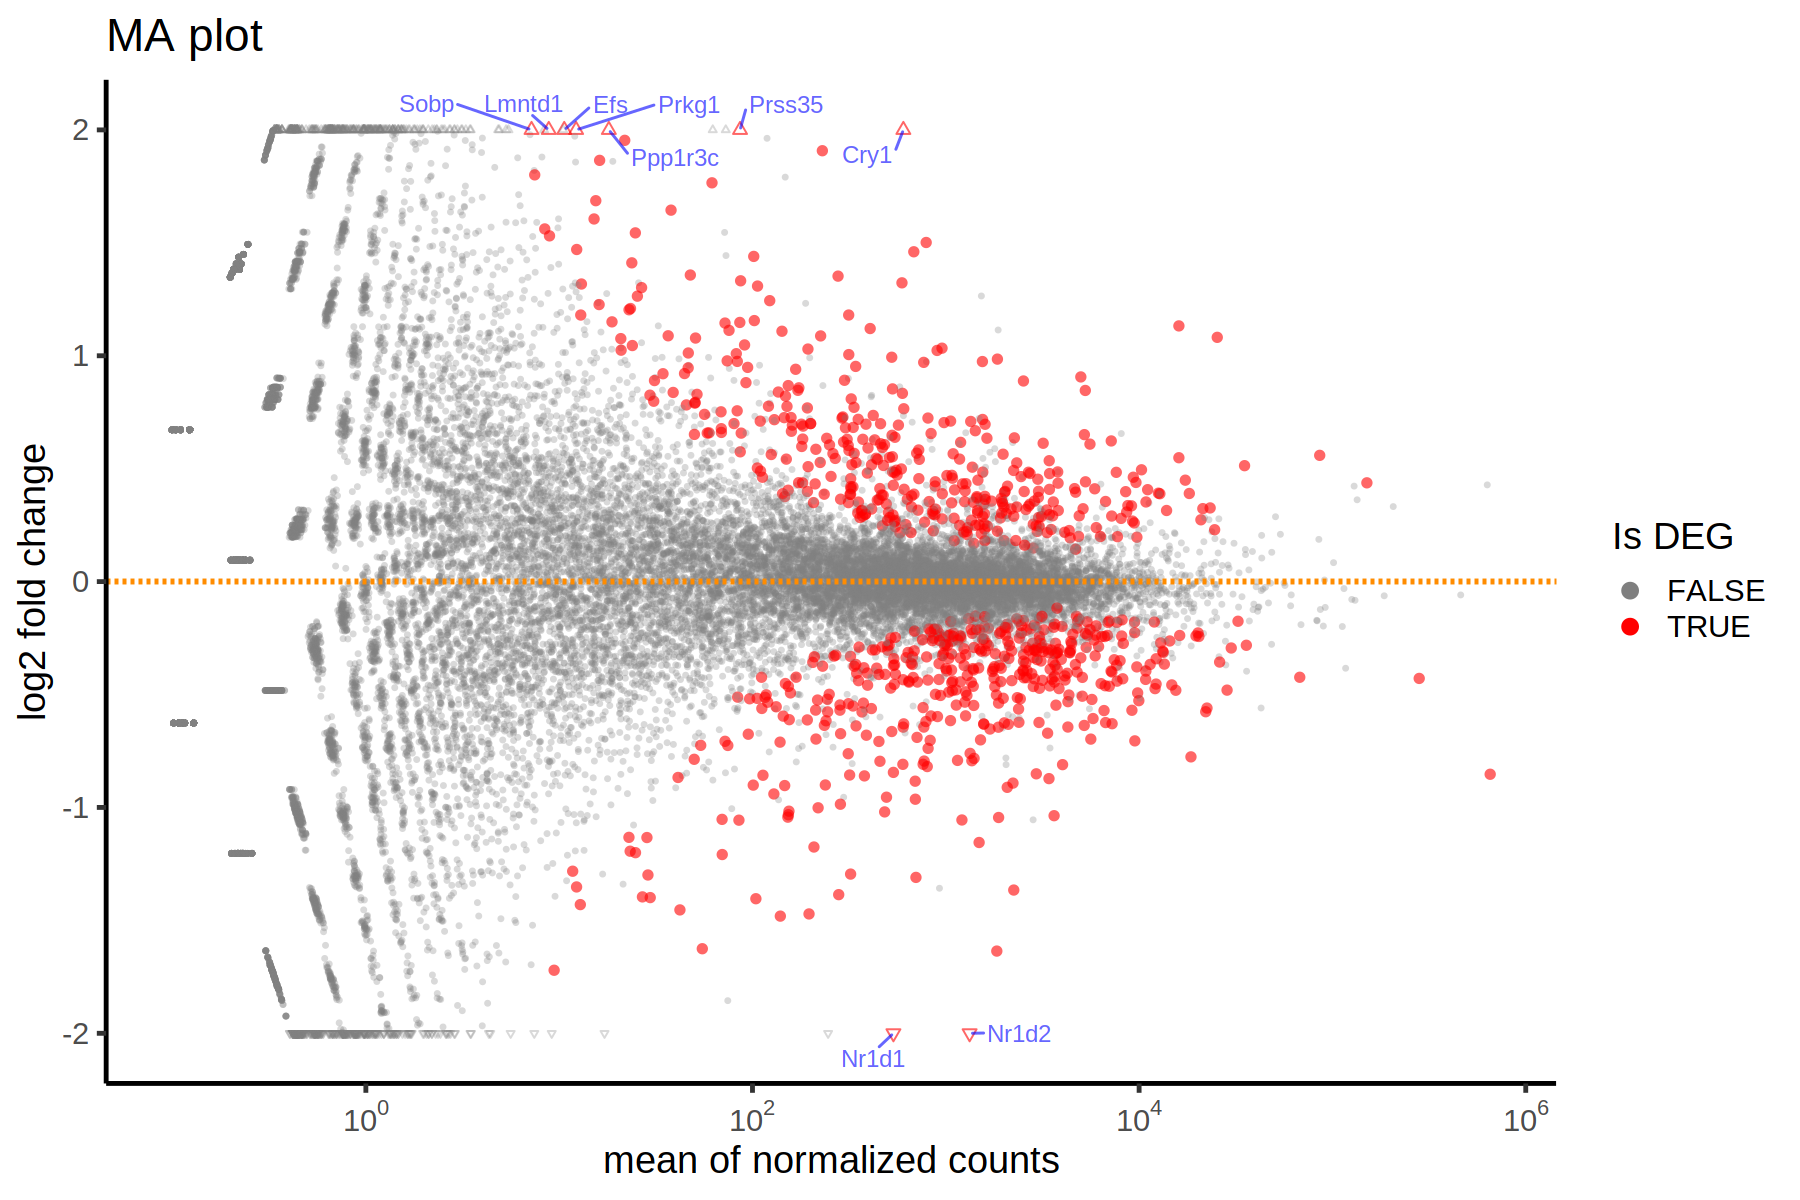

In [8]:
ggplot(data, aes(x = basemean, y = log2fc2, color = isDE, size = isDE, alpha = isDE, shape = shape)) + 
    geom_point() + theme_classic(base_size = 18) + 
    geom_hline(yintercept = 0, size = 1, color = "darkorange", linetype = "dashed") +
    scale_x_log10(breaks = log10break, labels = log10label) + 
    scale_y_continuous(limits = ylim*1.01) +
    scale_color_manual(name = "Is DEG", values = setNames(c("red", "gray50"), c(TRUE, FALSE))) +
    scale_alpha_manual(guide = FALSE, values = setNames(c(0.6, 0.3), c(TRUE, FALSE))) + 
    scale_size_manual(guide = FALSE, values = setNames(c(2, 1), c(TRUE, FALSE))) +
    scale_shape_manual(guide = FALSE, values = setNames(c(6, 2, 16), c("A", "B", "C"))) +
    guides(color = guide_legend(override.aes = list(size = 3))) +
    geom_text_repel(aes(label = ifelse(isDE == TRUE & abs(log2fc) > ylim[2], GeneSymbol, "")), # add labels
                    color = "blue", seed = 123, min.segment.length = unit(0, "lines"), 
                    box.padding = 0.5, size = 4, max.overlaps = Inf) +
    ggtitle("MA plot") + xlab("mean of normalized counts") + ylab("log2 fold change")

## 6. Notes

Differential expression analysis frameworks such as [limma](https://bioconductor.org/packages/limma), [edgeR](https://bioconductor.org/packages/edgeR) and [DESeq2](https://bioconductor.org/packages/DESeq2) each have its own function to produce a MA plot, and requires the input to be an object created as part of the analysis workflow. For example, DESeq2's `plotMA` function requires an a `DESeqResults` object produced by `results`; or a `DESeqDataSet` processed by `DESeq`, or the individual functions `nbinomWaldTest` or `nbinomLRT`.

You can use these build-in functions to create MA plot as part of the analysis. By using `ggplot2`, it can give you more flexibility and allows you to customised the layout and appearance.

## Session info

In [9]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 18.04.5 LTS

Matrix products: default
BLAS/LAPACK: /home/ihsuan/miniconda3/envs/jupyterlab/lib/libopenblasp-r0.3.12.so

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C               LC_TIME=en_GB.UTF-8       
 [4] LC_COLLATE=en_GB.UTF-8     LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                  LC_ADDRESS=C              
[10] LC_TELEPHONE=C             LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] scales_1.1.1      ggrepel_0.9.1     ggplot2_3.3.3     data.table_1.13.6

loaded via a namespace (and not attached):
 [1] Rcpp_1.0.6        pillar_1.4.7      compiler_4.0.3    base64enc_0.1-3   tools_4.0.3      
 [6] digest_0.6.27     uuid_0.1-4        jsonlite_1.7.2    evaluate_0.14     lifecycle_0.2.0  
